In [8]:
# dumping data from multiple csv files to sql workbench for ecommerce sql+python project 
# files are in python+sql folder

import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='SAMDynamo7',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/arshi/OneDrive/Desktop/python+sql'        # change the backward slashes from the copied path to forward slashes 

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='SAMDynamo7',
    database='ecommerce'
)
cur = db.cursor()

# BASIC QUERIES

# 1. List all unique cities where customers are located.

In [ ]:
query=''' select distinct customer_city from customers'''

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data)
df.head(10)

# 2. Count the number of orders placed in 2017.                                                                                                                    

In [ ]:
query=''' select count(order_id) from orders where year(order_purchase_timestamp)=2017'''

cur.execute(query)

data= cur.fetchall()

'total orders placed in 2017 are ',data[0][0]


# 3. Find the total sales per category.

In [2]:
import pandas as pd 
# multiple join (joining 3 tables)
query='''
select products.product_category as category,
round(sum(payments.payment_value),2) as sales
from products join order_items on products.product_id = order_items.product_id                
join payments on payments.order_id = order_items.order_id 
group by category 
'''

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data, columns=['category','sales'])
print(df)

                       category        sales
0                     perfumery   8107818.56
1          Furniture Decoration  22882822.27
2                     telephony   7790112.81
3                bed table bath  27400858.74
4                    automotive  13636709.30
..                          ...          ...
69               cds music dvds     19190.88
70                   La Cuisine     46616.48
71  Fashion Children's Clothing     12570.72
72                     PC Gamer     34790.88
73       insurance and services      5192.16

[74 rows x 2 columns]


# 4. Calculate the percentage of orders that were paid in installments.

In [ ]:
query = '''select sum(case when payment_installments >= 1 then 1 else 0 end )/ count(*) * 100  from payments ;'''

cur.execute(query)

data= cur.fetchall()

'the percentange of orders which are bought in installments are :',data  [0][0]

# 5. Count the number of customers from each state. 

In [ ]:
query = '''select count(customer_id),customer_state from customers group by customer_state;'''

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data ,columns=['customers','state'])
df

df=df.sort_values(by='customers',ascending= False)

plt.figure(figsize=(9,5))
plt.xticks(rotation=90)
plt.bar(df['state'],df['customers'])
plt.show()

# INTERMIDIATE QUERIES

# 1. Calculate the number of orders per month in 2018.

In [ ]:
query=''' select month(order_purchase_timestamp), count(order_id) from orders where year(order_purchase_timestamp)=2018 group by month(order_purchase_timestamp) '''

cur.execute(query)

data= cur.fetchall()
df = pd.DataFrame(data , columns=['month', 'order_count'])

o=[1,2,3,4,5,6,7,8]
ax=sns.barplot(x=df['month'],y=df['order_count'],data=df , order=o, color='red')
ax.bar_label(ax.containers[0])
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [ ]:
query = '''with count_per_order as (
select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items on 
orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average 
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average;'''

cur.execute(query)

data= cur.fetchall()
df = pd.DataFrame(data, columns =['city','average_products_per_order'])
df

# 3.Calculate the percentage of total revenue contributed by each product category.

In [ ]:
query='''
select upper(products.product_category) as category,
round((sum(payments.payment_value)/(select sum(payment_value)from payments))*100,2) as sales
from products join order_items on products.product_id = order_items.product_id                
join payments on payments.order_id = order_items.order_id 
group by category
'''

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data, columns=['Category','Sales %'])
print(df)

# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
import numpy as np
query='''
select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products 
join order_items on order_items.product_id = products.product_id
group by products.product_category; 
'''

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data, columns=['Category','Order_Count','Price'])
df

arr1=df['Order_Count']             # to find correlation 
arr2=df['Price']

a=np.corrcoef([arr1,arr2])
print('the correlation between price and the number of times a product has been purchased is :',a[0][1])

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [ ]:
query='''
select * , dense_rank() over (order by revenue desc) from 
(select order_items.seller_id, sum(payments.payment_value) as revenue
from order_items join payments on 
order_items.order_id = payments.order_id
group by seller_id) as a'''

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data,columns=['Seller_Id','Total Revenue','Rank'])
df=df.head(10)
sns.barplot(x='Seller_Id',y='Total Revenue', data=df, color='red')
plt.xticks(rotation=90)

plt.show()
df

# ADVANCED QUERIES

# 1. Calculate the moving average of order values for each customer over their order history.

In [ ]:

query='''select customer_id ,order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as moving_avg 
from
(select orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders on 
orders.order_id = payments.order_id) as a;
'''

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data,columns=['Customer_Id','order_purchase_timestamp','payment','moving_avg'])
df.head(20)

# 2. Calculate the cumulative sales per month for each year.

In [ ]:
query='''
select years,months ,payment ,sum(payment)
over(order by years, months) as cumulative_sum from
(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2)as payment from payments join orders on 
payments.order_id = orders.order_id
group by years,months order by years,months)as a;
'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Year','Column','Revenue','Cumulative_Sales'])
df

# 3. Calculate the year-over-year growth rate of total sales.

In [18]:
import pandas as pd 
query='''
with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2)as payment from payments join orders on 
payments.order_id = orders.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years))/
lag(payment,1) over(order by years))*100 from a ;
'''

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data,columns=['Years','Year_over_year_%_growth'])
df

,Years,Year_over_year_%_growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


#  4.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [3]:
query='''
with a as(select customers.customer_id ,
min(order_purchase_timestamp) as first_order
from orders 
join customers 
on customers.customer_id = orders.customer_id
group by customers.customer_id),                                  

b as (select a.customer_id , 
count( distinct order_purchase_timestamp) as next_order
from a join orders on 
orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b on 
a.customer_id=b.customer_id
; 

'''
# since none of our customers are repeated ,th query will return null or none 
cur.execute(query)
data=cur.fetchall()
data 

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

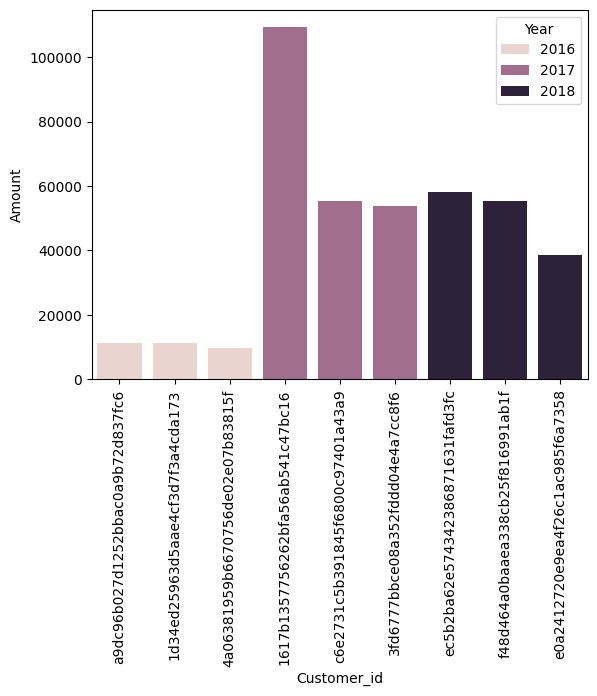

In [7]:
query='''
select years,customer_id , payment , D_Rank  
from  
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id ,
sum(payments.payment_value) as payment ,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) as D_Rank
from orders join payments on 
payments.order_id = orders.order_id
group by orders.order_purchase_timestamp,
orders.customer_id) as a
where D_Rank <= 3 
;
'''

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Year','Customer_id','Amount','Rank'])
df
sns.barplot(x='Customer_id',y='Amount',data=df,hue='Year')
plt.xticks(rotation = 90)
plt.show()